# **Child Mind Institute: Problematic Internet Use (Kaggle Competition Notebook)**

View this project on [GitHub]()

### ‣ 🧑‍💻 The Problem at Hand *(taken from the comptetition homepage 👉  [read here](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/overview))*

"In today’s digital age, problematic internet use among children and adolescents is a growing concern. Better understanding this issue is crucial for addressing mental health problems such as depression and anxiety.

Current methods for measuring problematic internet use in children and adolescents are often complex and require professional assessments. This creates access, cultural, and linguistic barriers for many families. Due to these limitations, problematic internet use is often not measured directly, but is instead associated with issues such as depression and anxiety in youth.

Conversely, physical & fitness measures are extremely accessible and widely available with minimal intervention or clinical expertise. Changes in physical habits, such as poorer posture, irregular diet, and reduced physical activity, are common in excessive technology users. We propose using these easily obtainable physical fitness indicators as proxies for identifying problematic internet use, especially in contexts lacking clinical expertise or suitable assessment tools."

**What does this mean?** The Child Mind Institute has tasked the public with building predictive machine learning models that will determine a participant's Severity Impairment Index (SII) - a metric measuring the level of problematic internet use among children and adolescents - based on physical activity, health, and other factors. The aim is to improve our ability to identify signs of problematic internet use early so preventative intervention can take place.

### ‣ 📊 The Data at Hand

From the institute's *Healthy Brain Network*, we have been provided with a roughly 4,000-entry dataset comprising measurements from various instruments, assessments, and questionairres - in particular, an assessment called the "Parent-Child Internet Addiction Test" (PCIAT), which is used to calculate the SII of each participant. We have also been given a collection of time-series data, collected via a wrist accelerometer given to roughly 1,000 participants to wear for up to 30 days continually while at home and going about their daily lives. The competition is largely concerned with the first dataset, but we will investigate the latter near the end of the notebook.

We have been provided with a **train set** on which we will train our models, and a **test set** on which we will evaluate their performance and generate our submission. The train set is the full dataset with **over 70 features**, including SII (**target variable**) and the PCIAT results used to calculate it. The test set is a much smaller collection of data with about 20 rows, and missing these features. *Our objective then is to train the models to accurately predict SII values for each entry in the test set.* We'll be using an *ensemble approach*, pre-processing and training two models separately and merging results for the final submission. 

### ‣ 📝 Competition Evaluation

The result will be evaluated based on the **quadratic weighted kappa**, a metric measuring the agreement between two outcomes. Our submission will consist of two rows, one for id and one for SII, with an entry for each participant in the test set. An example submission has been given to us to view.

In [1]:
# load pandas
import pandas as pd

# load sample submission
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")

# display sample submission
print("Sample submission")
print(f"Submission shape: {sample.shape}")
sample

Sample submission
Submission shape: (20, 2)


,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,2
3,00115b9f,3
4,0016bb22,0
5,001f3379,1
6,0038ba98,2
7,0068a485,3
8,0069fbed,0
9,0083e397,1


### ‣ 📚 Credit

*Parts of this notebook's EDA section were adapted from [Antonina Dolgorukova](https://datadelic.dev/)'s brilliant feature EDA notebook for this competition. I highly encourage checking out her work - it is extremely in-depth and well written!* 👉   [read it here](https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-features-eda/notebook)

***

## 🎬 ***Getting Started***

Let's start by taking a peek into our data and observing the features of the set.

In [2]:
import warnings

# load train set
train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")

# display first 5 rows of train set
print("""Train set: where the 'features' live""")
print(f"Train shape: {train.shape}")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(train.head())


Train set: where the 'features' live
Train shape: (3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While this is just a snippet, we can see the SII and the PCIAT scores on the right side of the set. The SII scores range from 0 to 3, with 0 representing no impairment and 3 representing severe impairment. So, we can think of the problem as training our models to **classify** each id in the test set into one of the 4 SII classes (0, 1, 2 or 3). A classification pipeline calls for what is known as **supervised learning**.

In [3]:
# load test set
test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

# display first 5 rows of test set
print("""Test set: what we will evaluate our models on""")
print(f"Test shape: {test.shape}")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(test.head())

Test set: what we will evaluate our models on
Test shape: (20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see some features that are pretty intuitive like *age*, *sex*, and *height*, but it can be tricky to figure out what all of these abbreviations mean - thankfully, the Child Mind Institute was kind enough to include a **data dictionary** for this competition, which gives some extra information on each feature. We'll load a little preview, but [you can view the full file on the Kaggle page.](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data?select=data_dictionary.csv)

In [4]:
# load data dictionary
data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

# display first 5 rows of data dictionary
print("""Data Dictionary: what each feature means""")
print(f"Data Dictionary shape: {data_dict.shape}")
display(data_dict.head())

Data Dictionary: what each feature means
Data Dictionary shape: (81, 6)


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


This should give us a brief overview of what we're working with. Throughout this notebook, we'll be utilizing libraries like numpy, pandas, matplotlib, seaborn, and scikit-learn frequently for manipulation, visualization, and machine learning. We'll import them here.

In [5]:
# load all other libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import lightgbm as lgb
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_categorical_dtype, CategoricalDtype
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
warnings.filterwarnings("ignore", category=RuntimeWarning)

***

## 🧐 ***Exploratory Data Analysis (EDA)***

It can be tricky to know where to start with EDA, since there's so much to work with - but let's begin by taking a closer look at the PCIAT features, or in other words, all the features that in the train set but not in the test set.

In [6]:
# isolating train-only features
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))

# addind additional information using data dictionary
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


Here we see that each item in the Parent-Child Internet Addiction Test (PCIAT) is a question assessing a different aspect of a child's behavior related to internet use, with responses given on a scale from 0 to 5 - the total score, PCIAT_Total, indicates the severity of internet addiction. PCIAT_Total should directly align with SII, but let's verify this by calculating the minimum and maximum scores for each SII category.

In [7]:
# calculate max and min
pciat_min_max = train.groupby('sii', observed=True)['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'})
display(pciat_min_max)

# print range for each level of severity
print(data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0])

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe


So essentially, the answers to the PCIAT questions are totaled, and each participant is given an SII of 0-3 based on the range of their total score. Simple!

But wait, what about missing values? Say, for instance, a participant sees a question that *really hits close to home*, and they skip it. Maybe they skip many questions. How does the assessment account for this?

In [8]:
# display section with missing values highlighted
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.map(lambda x: 'background-color: #FFC0CB' if pd.isna(x) else '')

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


**The problem:** the SII score is calculated by adding together all of the *non-NA* (non-empty) values in the test, meaning a participant can ignore every question (like the second participant) and still get a score of 0. Entries like this are obviously not reliable, and will skew the results. We can assume then that the SII score can sometimes be incorrect.

We can address this though, by recalculating the SII scores ourselves based on the maximum possible PCIAT_Total score *IF* missing values were answered. That way, participants who skip the survey will not be labeled as having no severity, but will instead be given a "missing" label.

In [9]:
# isolate PCIAT columns
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]

# define function to recalculate SII accounting for missing PCIAT values
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan
train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

# overwriting SII with recalc_SII and adding labels 'missing', 'none', 'mild', 'moderate', 'severe'
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(train[PCIAT_cols].notna().all(axis=1), np.nan)
sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')
sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)
train.drop(columns='recalc_sii', inplace=True)

Now with our SII values recalculated and updated, we can remove all duplicate rows, and all rows with "missing" in the SII column.

**Why?** Well, we don't want to train our model on values that aren't there.

In [10]:
# remove rows with no SII
initial_rows = len(train)
train = train[train['sii'] != 'Missing']
train['sii'] = train['sii'].cat.remove_unused_categories()
removed_rows = initial_rows - len(train)
print(f"Removed {removed_rows} rows with 'Missing' SII values.")
print(f"Train shape: {train.shape}")

# check for/ remove duplicate rows (if present)
duplicate_count = train.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Removed 1241 rows with 'Missing' SII values.
Train shape: (2719, 83)
Duplicate rows: 0


Finally, before we start creating visualizations, let's define a helper function for generating summary statistics for any given column - this will come in handy during analysis.

In [11]:
# define helper function for gathering information from given column(s)
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]
    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)
    return pd.concat(stats, axis=0)

🖼️ ***With that, it's time to start visualizing!***

First, let's view the distributions for the target variable SII, as well as for the corresponding PCIAT scores.

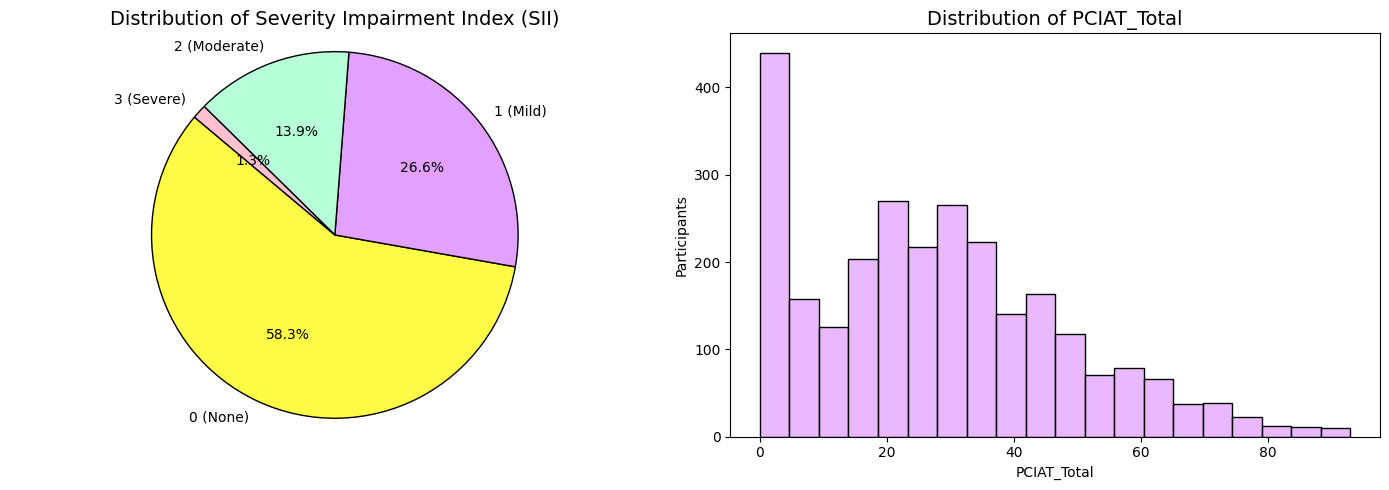

In [12]:
warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*")

# helper variables for EDA
sii_counts = train['sii'].value_counts().reset_index()
sii_counts.columns = ['SII', 'Count']
total = sii_counts['Count'].sum()
sii_counts['percentage'] = (sii_counts['Count'] / total) * 100
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# generate custom color pallete: bright yellow, lavender, mint green, light pink, sky blue
custom_palette = ['#FFFB46', '#E2A0FF', '#B7FFD8', '#FFC1CF', '#C4F5FC']

# create pie chart: distribution of participant SII
axes[0].pie(sii_counts['Count'], labels=sii_counts['SII'], autopct='%1.1f%%', colors=custom_palette, startangle=140, wedgeprops={'edgecolor': 'black'})
axes[0].set_title('Distribution of Severity Impairment Index (SII)', fontsize=14)
axes[0].axis('equal')

# create histogram: distribution of participant PCIAT_Total
sns.histplot(train['complete_resp_total'].dropna(), bins=20, color='#E2A0FF', ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total')
axes[1].set_ylabel('Participants')
plt.tight_layout()
plt.show()

A couple things here - first, we can see that about 60% of participants have an SII score of 0, which we can basically interpret as, 60% of participants reporting that they are not impaired by internet use whatsoever. *Yeah, doubtful.* Following that, 26% are mildly impaired, and only a little over 1% are severely impaired. PCIAT scores seem to mostly follow a normal curve, with obvious exception being the giant spike at 0. With reasonable assurance, we can assume that the self-reported format of the assessment has led to some responses that are... *disingenuous,* to say the least.

But, let us in this moment give humanity the benefit of the doubt and proceed with our analysis. Next we'll use our handy **calculate_stats** funtion to take a look at some basic participant demographics like age and sex, and see how SII distributes over these metrics.

In [13]:
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

# create table: distribution of participant Age Group
train['Age Group'] = pd.cut(train['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)'])
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2061 (75.8%)
Adolescents (13-18),623 (22.91%)
Adults (19-22),35 (1.29%)


In [14]:
# create table: distribution of participant Sex
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

,count (%)
Basic_Demos-Sex,
Male,1729 (63.59%)
Female,990 (36.41%)


In [15]:
# create table: distribution of SII by Age Group
stats_age = train.groupby(['Age Group', 'sii'], observed=False).size().unstack(fill_value=0)
stats_age_prop = stats_age.div(stats_age.sum(axis=1), axis=0) * 100
stats_age = stats_age.astype(str) +' (' + stats_age_prop.round(1).astype(str) + '%)'
stats_age

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,
Children (5-12),1359 (65.9%),493 (23.9%),203 (9.8%),6 (0.3%)
Adolescents (13-18),211 (33.9%),217 (34.8%),169 (27.1%),26 (4.2%)
Adults (19-22),16 (45.7%),12 (34.3%),5 (14.3%),2 (5.7%)


In [16]:
# create table: distribution of SII by Sex
stats_sex = train.groupby(['Basic_Demos-Sex', 'sii'], observed=False).size().unstack(fill_value=0)
stats_sex_prop = stats_sex.div(stats_sex.sum(axis=1), axis=0) * 100
stats_sex = stats_sex.astype(str) +' (' + stats_sex_prop.round(1).astype(str) + '%)'
stats_sex

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Basic_Demos-Sex,,,,
Female,634 (64.0%),247 (24.9%),101 (10.2%),8 (0.8%)
Male,952 (55.1%),475 (27.5%),276 (16.0%),26 (1.5%)


The tables show us that the majority of the participants are children, with fewer adolescents and very few adults. The participant pool is also interestingly two-thirds male, **which is significant - this means the model will be essentially gender-biased.** It is plausible that this was intentional by the institute.

The distribution of SII scores for the "children" and "adults" groups is skewed towards lower values, while scores for adolescents are relatively balanced across the categories, following something of a reverse-U shape. We also might notice that there are significantly more severe cases for males, but considering the sample is heavily skewed male, the differences between SII distribution in males and females are likely not significant.

📲 ***Internet Use:***

You might have noticed in our data samples a variable called "PreInt_EduHx-computerinternet_hoursday". This measures the number of hours participants spend on the internet per day - naturally, since we are investigating internet addiction, this variable warrants some deeper analysis. Let us first take a look at how long different age groups spend online.

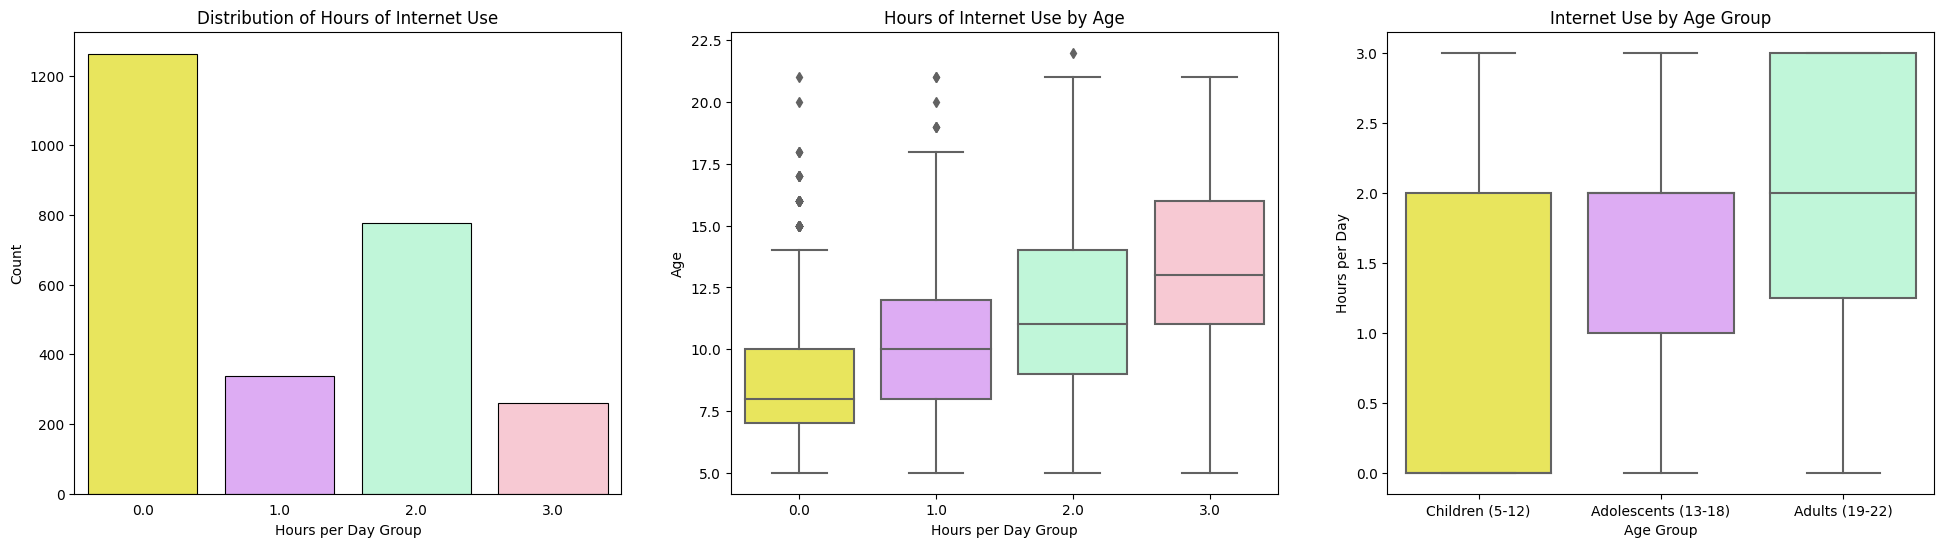

In [17]:
warnings.filterwarnings("ignore", message=".*observed=False is deprecated.*")
fig, axes = plt.subplots(1, 3, figsize=(24, 6)) 

# create bar chart: distribution of Hours of Internet Use
ax1 = sns.countplot(x='PreInt_EduHx-computerinternet_hoursday', data=train, palette=custom_palette[:4], ax=axes[0], edgecolor='black', linewidth=0.8)
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=True)

# create boxplot: Hours of Internet Use vs Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['PreInt_EduHx-computerinternet_hoursday'], palette=custom_palette[:4], ax=axes[1])
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# create boxplot: Hours of Internet Use vs Age Group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', data=train, palette=custom_palette[:3], ax=axes[2])
axes[2].set_title('Internet Use by Age Group')
axes[2].set_ylabel('Hours per Day')
axes[2].set_xlabel('Age Group');

Following from the tables we analyzed previously, we can see that higher internet usage is linked to older age, hinting towards a correlation between hours of internet use and SII scores.

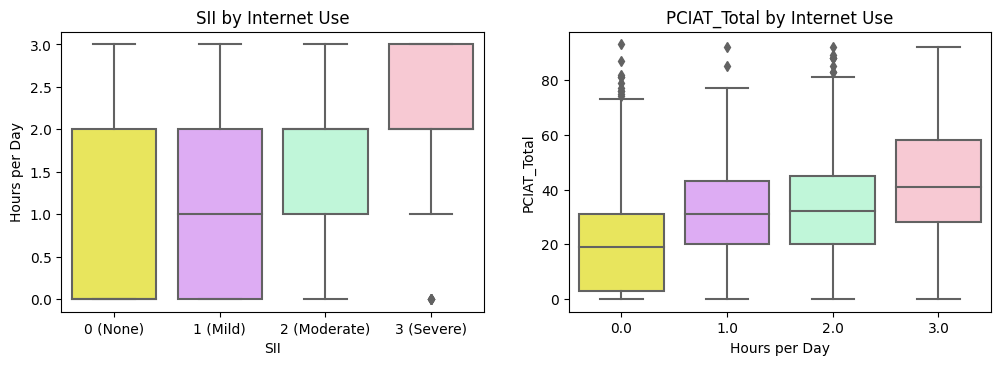

In [18]:
warnings.filterwarnings("ignore", message=".*observed=False is deprecated.*")
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

# create boxplot: SII vs Hours of Internet Use
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(x='sii', y='PreInt_EduHx-computerinternet_hoursday', data=train, ax=ax1, palette=custom_palette[:4])
ax1.set_title('SII by Internet Use')
ax1.set_ylabel('Hours per Day')
ax1.set_xlabel('SII')

# create boxplot: PCIAT_Total vs Hours of Internet Use
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x='PreInt_EduHx-computerinternet_hoursday', y='complete_resp_total', data=train, palette=custom_palette[:4], ax=ax2)
ax2.set_title('PCIAT_Total by Internet Use')
ax2.set_ylabel('PCIAT_Total')
ax2.set_xlabel('Hours per Day');

Sure enough - simply tracing your finger across the plots, a slight upward trend is visible between SII/ PCIAT and hours of internet use, signaling their clear correlation. This result makes intuitive sense and shouldn't come as a surprise. We can also discern from our analysis so far that *while adults spend the most time using the internet, adolescents are the most likely to report a high SII score.*

It might also be notable that there are plenty of participants across all age groups that report less than an hour of internet use AND a high SII score, showing that for some participants, only an hour of internet use can be enough to negatively impact their mental health. 

🫀 ***Physcial Activity:***

What about the participants' physical attributes? A significant portion of the dataset is dedicated to metrics like height, weight, BMI, heart rate, etc. The relationship between internet use and SII makes sense, but analysis of these metrics might yield some interesting and unexpected results.

Looking at our data, there just so happen to be 7 primary physical metrics: BMI, Height, Weight, Waist Circumference, Heart Rate, and Diastolic and Systolic BP (Blood Pressure). This is the perfect number of features for building a **correlation matrix**, where each feature is given a score from -1 to 1, based on its correlation with the target variable (positive values indicate positive correlation, negative values indicate negative correlation, and 0 indicates no correlation).

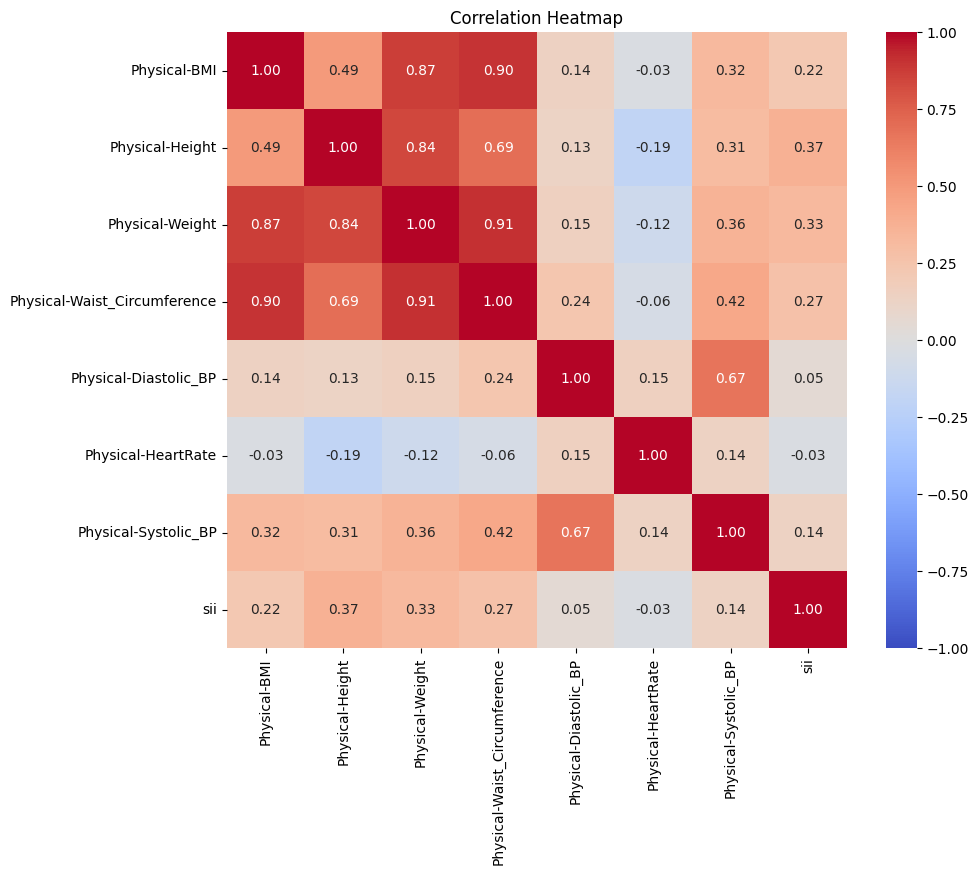

In [19]:
# covert SII values to float type
train['sii'] = train['sii'].str[0].astype(float)

# isolate physical features
physical_cols = ['Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']
data_subset = train[physical_cols + ['sii']]

# generate correlation heatmap matrix for physical features
corr_matrix = data_subset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Each square reads the correlation coefficeint between the two features intersecting at that square, with positive correlations marked red and negative correlations marked blue. Right away we notice strong positive correlations in the top right corner - this is where variables like height, weight, BMI and waist circumference all intersect with one another. But what we are really interested in is how these features are correlated with SII.

Looking at the bottom row, we see that height, weight and waist circumference all have positive correlations with SII, while dialostic blood pressure, systolic blood pressure and heart rate are weakly correlated. **Interesting!** This would suggest that taller and heavier participants are more likely to have higher SII scores, while cardiovascular health is not a determining factor for SII.

*It should be noted:* since height and weight increase with age, some of this correlation is likely our previously observed age correlation in disguise. Let us investigate.

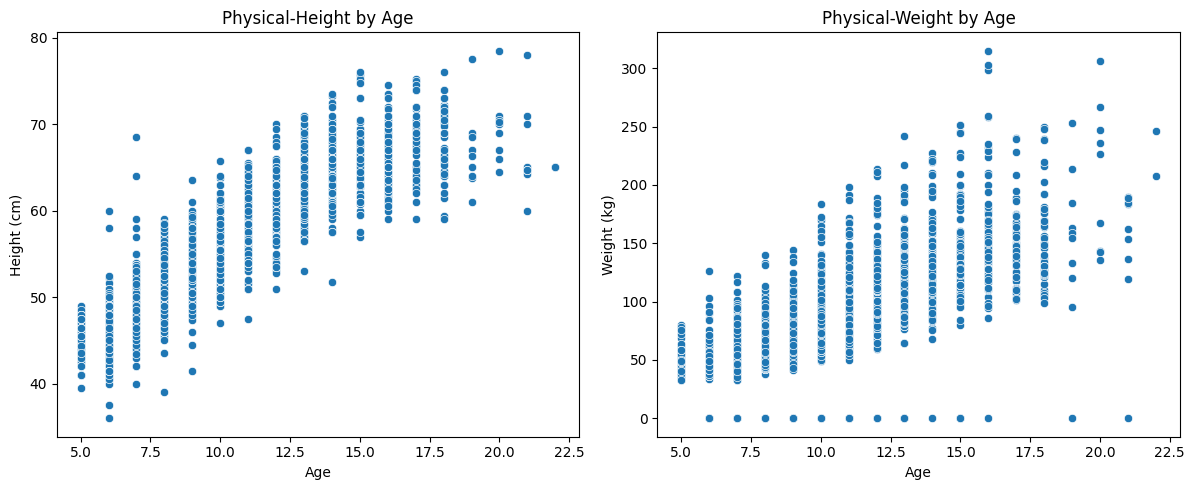

In [20]:
plt.figure(figsize=(18, 5))

# create scatterplot: Height vs Age
plt.subplot(1, 3, 1)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Height', data=train)
plt.title('Physical-Height by Age')
plt.xlabel('Age')
plt.ylabel('Height (cm)')

# create scatterplot: Weight vs Age
plt.subplot(1, 3, 2)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Weight', data=train)
plt.title('Physical-Weight by Age')
plt.xlabel('Age')
plt.ylabel('Weight (kg)')
plt.tight_layout()
plt.show()

No surprises here - however, we can see a number of outliers in the weight measurements, possibly suggesting some input error. This might have an effect on the correlation between weight and SII.

We saw that height, weight and BMI have the strongest correlation with SII, so let's take a closer look at those.

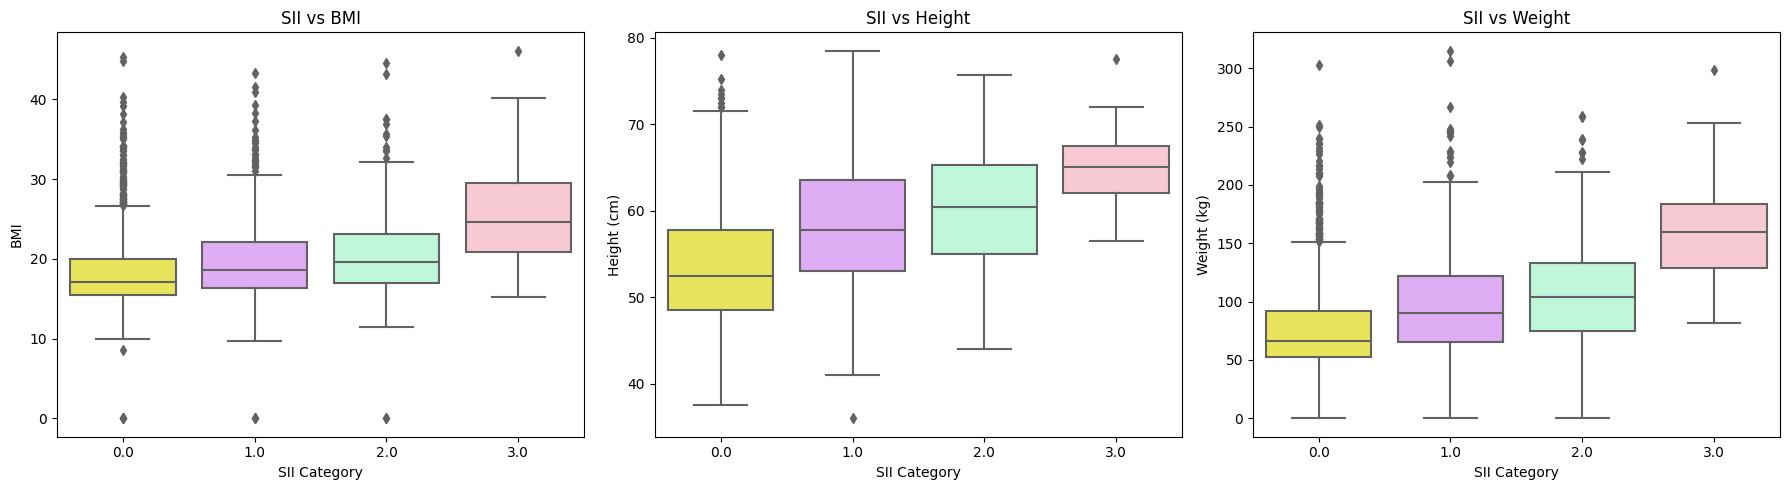

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# create boxplot: SII vs BMI
sns.boxplot(x='sii', y='Physical-BMI', data=train, ax=axes[0], palette=custom_palette[:4])
axes[0].set_title('SII vs BMI')
axes[0].set_xlabel('SII Category')
axes[0].set_ylabel('BMI')

# create boxplot: SII vs Height
sns.boxplot(x='sii', y='Physical-Height', data=train, ax=axes[1], palette=custom_palette[:4])
axes[1].set_title('SII vs Height')
axes[1].set_xlabel('SII Category')
axes[1].set_ylabel('Height (cm)')

# create boxplot: SII vs Weight
sns.boxplot(x='sii', y='Physical-Weight', data=train, ax=axes[2], palette=custom_palette[:4])
axes[2].set_title('SII vs Weight')
axes[2].set_xlabel('SII Category')
axes[2].set_ylabel('Weight (kg)')
plt.tight_layout()
plt.show()

Here we can see something kind of interesting - there is a pretty sharp jump in BMI and weight when SII is 3, suggesting that **weight** may play a significant factor in severe internet addiction, which is plausible. A positive correlation also exists with height, but the increase is gradual and less dramatic.

🏠 ***Bringing it Home:***

At this point, we have a decent understanding of the data at hand. To conclude our analysis, let us calculate the **Pearson correlation coefficient** between each feature and SII, like we did with the physical measures - this will help us determine which features to utilize in feature engineering and model training, and which features are less relevant.

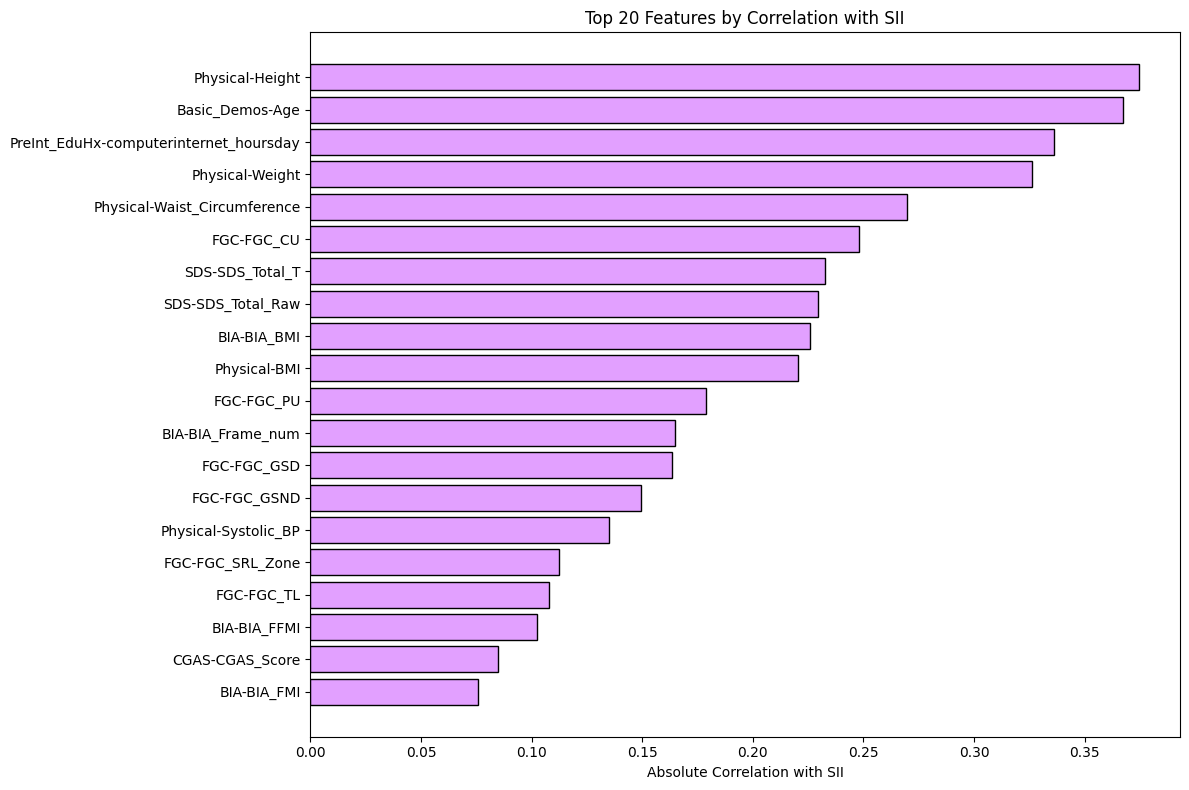

In [22]:
# isolate non-PCIAT features
train_subset = train.drop(train.columns[55:76].tolist() + ['complete_resp_total'], axis=1)
numerical_features = train_subset.select_dtypes(include=[np.number]).columns.tolist()

# calculate Pearson correlations with 'sii'
target_correlations = []
for feature in numerical_features:
    if feature != 'sii':
        corr = train_subset[[feature, 'sii']].corr().iloc[0, 1]
        if not np.isnan(corr):
            target_correlations.append((feature, abs(corr)))

# sort and select top 20
top_corr = sorted(target_correlations, key=lambda x: x[1], reverse=True)[:20]
features, corrs = zip(*top_corr)

# create bar chart of features by correlation with SII
plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), corrs, color='#E2A0FF', edgecolor='black')
plt.yticks(range(len(features)), features)
plt.xlabel('Absolute Correlation with SII')
plt.title('Top 20 Features by Correlation with SII')
plt.gca().invert_yaxis()  # Optional: highest at top
plt.tight_layout()
plt.show()

This confirms much of what we found earlier - features like height, weight, age, and internet use, have a strong positive correlation with SII score. In interpreting these results, we must remember the time-old logical fallacy: *"correlation does not imply causation"*. Pearson correlation (same correlation as used in the matrix) doesn't say that any of these features **cause** SII, only that when one is higher, the other also tends to be higher.

We can see many many other features we did not analyze as closely also have positive correlations with SII. Not to worry, these will be accounted for in the feature engineering and selection process.

🥡 ***Key Takeaways:***

‣ Roughly 85% of participants report and SII of either 0 or 1.

‣ The largest share of high SII scores are found in adolescents, with children and adults following.

‣ Physical attribures (BMI, height, weight, waist circumference) are among the features with the strongest positive correlations with SII.

‣ SII increases with internet use, and internet use increases with age.

‣ The dataset overall skews male.

***

## 🏋️ ***Model Training!***

We are now ready to start our model training pipeline! This involves some final data cleaning, general feature engineering, pre-processing for each model, and finally, model training and validation. We will train two models: a **Ridge Regression model** and a **LightGBM (Gradient Boosting Machine) model**. Ridge Regression is a linear regression model that uses correlation to determine feature importance, while LightGBM is a gradient boosting machine that can handle non-linear relationships and complex interactions between features. Ridge is a simpler baseline ML model, while LightGBM is more complex and requires more computing power.

Training multiple models and combining their results is known as *ensembling,* and is a common tactic to generate balanced, unbiased results. If one model is improperly trained, or displays significant **overfitting** (when a model only performs well on the training data), the other model can make up for this deficiency.

Before we begin, we want to ensure our dataset only contains features we want to train on, so let's remove all features that are directly related to SII, like PCIAT scores, and arbitrary identifiers like "id". 

In [23]:
# permanentlyremove all PCIAT columns
pciat_cols = [col for col in train.columns if 'PCIAT' in col]
train = train.drop(columns=pciat_cols)

# remove "complete_resp" and "age group" columns
train = train.drop("complete_resp_total", axis=1)
train = train.drop("Age Group", axis=1) 

# remove id column
train = train.drop("id", axis=1)

Next, let's get ready for feature engineering by separating our data into categorical and numerical columns. We'll then re-calculate the absolute Pearson correlations with the target variable (SII) for the numerical features, before using them to create engineered features.

In [24]:
# separate SII from features
X = train.drop('sii', axis=1)
y = train['sii']

# create sets for categorical and numerical features
categorical_cols = []
numerical_cols = []
for col in X.columns:
    if X[col].dtype == 'object':
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

# re-calculate Pearson correlation coefficients for numerical columns (corr. with SII)
def calculate_correlations(X, y, numerical_cols):
    correlations = {}
    for col in numerical_cols:
        mask = ~(X[col].isnull() | y.isnull())
        if mask.sum() > 1:
            corr, p_value = pearsonr(X[col][mask], y[mask])
            correlations[col] = {'correlation': corr, 'p_value': p_value}
    return correlations
correlations = calculate_correlations(X, y, numerical_cols)

# sort features by correlation
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)
print("\nTop 20 correlations with SII (absolute correlation):")
for i, (col, stats) in enumerate(sorted_correlations[:20]):
    print(f"{i+1:2d}. {col:<40} | Corr: {stats['correlation']:6.3f} | p-value: {stats['p_value']:.4f}")


Top 20 correlations with SII (absolute correlation):
 1. Physical-Height                          | Corr:  0.374 | p-value: 0.0000
 2. Basic_Demos-Age                          | Corr:  0.368 | p-value: 0.0000
 3. PreInt_EduHx-computerinternet_hoursday   | Corr:  0.336 | p-value: 0.0000
 4. Physical-Weight                          | Corr:  0.326 | p-value: 0.0000
 5. Physical-Waist_Circumference             | Corr:  0.270 | p-value: 0.0000
 6. FGC-FGC_CU                               | Corr:  0.248 | p-value: 0.0000
 7. SDS-SDS_Total_T                          | Corr:  0.233 | p-value: 0.0000
 8. SDS-SDS_Total_Raw                        | Corr:  0.230 | p-value: 0.0000
 9. BIA-BIA_BMI                              | Corr:  0.226 | p-value: 0.0000
10. Physical-BMI                             | Corr:  0.220 | p-value: 0.0000
11. FGC-FGC_PU                               | Corr:  0.179 | p-value: 0.0000
12. BIA-BIA_Frame_num                        | Corr:  0.165 | p-value: 0.0000
13. FGC-FG

This largely follows from our EDA, only this time we see some features with negative correlation. There's nothing wrong with this - in fact, negative correlations are just as informative as positive ones, only in the opposite direction.

⚙️ ***Feature Engineering:***

We'll engineer features in two different ways - some based on out own domain knowledge, and some based on correlation with the SII. 

***Custom features:***

‣ Difference between Physical BMI and Bio-electric Impedance Analysis (BIA) BMI (different assessments - BIA incorporates internal composition, while Physical BMI is a crude ratio)

‣ Duration of Total Exercise (in seconds)

‣ Ratio of Fat to FFM (body fat percentage to fat-free mass)

‣ Z-score normalation of cardiovascular health statistics (heart rate, systolic and diastolic blood pressure)

‣ Age Squared and Age Group (self-explanatory)

In [25]:
# define function to engineer new features
def create_engineered_features(df, correlations=None):
    df_eng = df.copy()
    
    # BMI-related features
    if 'Physical-BMI' in df_eng.columns and 'BIA-BIA_BMI' in df_eng.columns:
        df_eng['BMI_difference'] = df_eng['Physical-BMI'] - df_eng['BIA-BIA_BMI']
    
    # fitness ratios
    if 'Fitness_Endurance-Time_Mins' in df_eng.columns and 'Fitness_Endurance-Time_Sec' in df_eng.columns:
        df_eng['Total_Fitness_Time'] = df_eng['Fitness_Endurance-Time_Mins'] * 60 + df_eng['Fitness_Endurance-Time_Sec']
    
    # body composition ratios
    if 'BIA-BIA_Fat' in df_eng.columns and 'BIA-BIA_FFM' in df_eng.columns:
        df_eng['Fat_to_FFM_ratio'] = df_eng['BIA-BIA_Fat'] / (df_eng['BIA-BIA_FFM'] + 1e-8)
    
    # physical health composite
    if all(col in df_eng.columns for col in ['Physical-HeartRate', 'Physical-Systolic_BP', 'Physical-Diastolic_BP']):
        health_cols = ['Physical-HeartRate', 'Physical-Systolic_BP', 'Physical-Diastolic_BP']
        for col in health_cols:
            if df_eng[col].notna().sum() > 0:
                mean_val = df_eng[col].mean()
                std_val = df_eng[col].std()
                df_eng[f'{col}_normalized'] = (df_eng[col] - mean_val) / (std_val + 1e-8)
    
    # age-related
    if 'Basic_Demos-Age' in df_eng.columns:
        df_eng['Age_squared'] = df_eng['Basic_Demos-Age'] ** 2
        df_eng['Age_group'] = pd.cut(df_eng['Basic_Demos-Age'], 
                                   bins=[0, 8, 12, 16, 22], 
                                   labels=['child', 'preteen', 'teen', 'young_adult'])
    
    # features based on correlation
    if correlations is not None:
        top_corr_features = [col for col, stats in sorted(correlations.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)[:10] if col in df_eng.columns]
        for i, col1 in enumerate(top_corr_features[:5]):
            for col2 in top_corr_features[i+1:5]:
                if col1 in df_eng.columns and col2 in df_eng.columns:
                    if df_eng[col1].dtype in ['int64', 'float64'] and df_eng[col2].dtype in ['int64', 'float64']:
                        df_eng[f'{col1}_x_{col2}'] = df_eng[col1] * df_eng[col2]
    return df_eng

# apply feature engineering function to train set
X_engineered = create_engineered_features(X, correlations)
print("New features created:")
new_features = set(X_engineered.columns) - set(X.columns)
for feat in new_features:
    print(f"  - {feat}")

New features created:
  - Basic_Demos-Age_x_Physical-Weight
  - Physical-Systolic_BP_normalized
  - Total_Fitness_Time
  - Physical-Height_x_Basic_Demos-Age
  - Fat_to_FFM_ratio
  - Physical-Height_x_Physical-Weight
  - BMI_difference
  - PreInt_EduHx-computerinternet_hoursday_x_Physical-Waist_Circumference
  - Age_squared
  - PreInt_EduHx-computerinternet_hoursday_x_Physical-Weight
  - Basic_Demos-Age_x_PreInt_EduHx-computerinternet_hoursday
  - Physical-Diastolic_BP_normalized
  - Physical-Height_x_Physical-Waist_Circumference
  - Physical-Weight_x_Physical-Waist_Circumference
  - Basic_Demos-Age_x_Physical-Waist_Circumference
  - Physical-Height_x_PreInt_EduHx-computerinternet_hoursday
  - Physical-HeartRate_normalized
  - Age_group


Here, we can see all of the features created through correlation marked with an "_x_", with our custom features sprinkled in throughout. Since many of these features were calculated *using* correlation, many of them will likely be more highly correlated with SII than the original features. Let us then calculate absolute correlations one last time.

In [26]:
# re-create categorical and numerical sets to include engineered features
categorical_cols_eng = []
numerical_cols_eng = []
for col in X_engineered.columns:
    if is_object_dtype(X_engineered[col]) or isinstance(X_engineered[col].dtype, CategoricalDtype):
        categorical_cols_eng.append(col)
    elif is_numeric_dtype(X_engineered[col]):
        numerical_cols_eng.append(col)
print(f"\nFinal categorical columns: {len(categorical_cols_eng)}")
print(f"Final numerical columns: {len(numerical_cols_eng)}")

# recalculate correlations with engineered features
correlations_eng = calculate_correlations(X_engineered, y, numerical_cols_eng)

# sort by absolute correlation
sorted_correlations_eng = sorted(correlations_eng.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)
print("\nTop 15 correlations with SII (after feature engineering):")
for i, (col, stats) in enumerate(sorted_correlations_eng[:15]):
    print(f"{i+1:2d}. {col:<40} | Corr: {stats['correlation']:6.3f} | p-value: {stats['p_value']:.4f}")


Final categorical columns: 12
Final numerical columns: 64

Top 15 correlations with SII (after feature engineering):
 1. Basic_Demos-Age_x_PreInt_EduHx-computerinternet_hoursday | Corr:  0.380 | p-value: 0.0000
 2. Physical-Height                          | Corr:  0.374 | p-value: 0.0000
 3. Physical-Height_x_Basic_Demos-Age        | Corr:  0.374 | p-value: 0.0000
 4. Basic_Demos-Age_x_Physical-Waist_Circumference | Corr:  0.372 | p-value: 0.0000
 5. Basic_Demos-Age                          | Corr:  0.368 | p-value: 0.0000
 6. Physical-Height_x_PreInt_EduHx-computerinternet_hoursday | Corr:  0.359 | p-value: 0.0000
 7. PreInt_EduHx-computerinternet_hoursday_x_Physical-Weight | Corr:  0.357 | p-value: 0.0000
 8. Age_squared                              | Corr:  0.346 | p-value: 0.0000
 9. Physical-Height_x_Physical-Waist_Circumference | Corr:  0.345 | p-value: 0.0000
10. Physical-Height_x_Physical-Weight        | Corr:  0.340 | p-value: 0.0000
11. Basic_Demos-Age_x_Physical-Weight     

Theoretically, we could repeat this process of engineering new features based on correlation, then re-calculating correlations for those new features, engineering new features again... and so on. But this is short-sighted - improvements would likely plateau quickly, and possibly even diverge into nonsense, so we'll stop here. These features should serve as a solid baseline, and our models will be able to take it from here.

One more thing before training. We of course have our **test set** to evaluate our models on, but we'll want to tune and adjust our models before we do that and need a way of evaluating our models' performance *without* using the test set. To do this, we can split our train set into a training set and a **validation set** we can experiment on. 

In [27]:
# split engineered data into train and validation sets, 80/ 20
X_train, X_val, y_train, y_val = train_test_split(X_engineered, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTrain set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Train set shape: (2175, 76)
Validation set shape: (544, 76)


⛰ ***Time to Train: Ridge Model***

First, the Ridge model. The pre-processing pipeline will select which features to use (based on correlation), fill missing values, scale the features to have zero mean and unit variance, and finally encode the categorical variables using **one-hot encoding**, so that the model can learn from them. After running through our engineered train and validation sets through this pipeline, we'll try training the Ridge model with a few different *correlation thresholds* (meaning, only features meeting a certain correlation threshold will be included in the training), and evaluate each on the validation set, calculating the **Root Mean Squared Error (RMSE)** between the model's predictions for SII and the actual SII values. Lower the validation RMSE, the more accurate the model.

We'll try 4 different correlation thresholds: 0.01, 0.03, 0.05, and 0.1, as well as one model with no threshold.

In [28]:
# RIDGE REGRESSION PREPROCESSING PIPELINE
print("\n" + "="*50)
print("RIDGE REGRESSION PREPROCESSING")
print("="*50)

# define function for feature selection based on threshold
def select_features_by_correlation(X, y, numerical_cols, threshold=0.05):
    correlations = calculate_correlations(X, y, numerical_cols)
    selected_features = []
    for col, stats in correlations.items():
        if abs(stats['correlation']) >= threshold and stats['p_value'] < 0.05:
            selected_features.append(col)
    return selected_features

# define ridge model preprocessing function
def preprocess_for_ridge(X_train, X_val, categorical_cols, numerical_cols, correlation_threshold=0.05, use_correlation_filtering=True):
    
    # create copies of sets
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    
    # missing values (fill numerical with median, categorical with mode)
    for col in numerical_cols:
        if col in X_train_processed.columns:
            median_val = X_train_processed[col].median()
            X_train_processed[col] = X_train_processed[col].fillna(median_val)
            X_val_processed[col] = X_val_processed[col].fillna(median_val)
    for col in categorical_cols:
        if col in X_train_processed.columns:
            mode_val = X_train_processed[col].mode()[0] if not X_train_processed[col].mode().empty else 'Unknown'
            X_train_processed[col] = X_train_processed[col].fillna(mode_val)
            X_val_processed[col] = X_val_processed[col].fillna(mode_val)
    
    # feature selection based on correlation
    selected_numerical_features = numerical_cols
    if use_correlation_filtering:
        selected_numerical_features = select_features_by_correlation(X_train_processed, y_train, numerical_cols, correlation_threshold)
        print(f"Selected {len(selected_numerical_features)} numerical features out of {len(numerical_cols)} based on correlation > {correlation_threshold}")
        print("Selected features:", selected_numerical_features[:10], "..." if len(selected_numerical_features) > 10 else "")
        
        # keep only selected numerical features
        features_to_keep = selected_numerical_features + categorical_cols
        X_train_processed = X_train_processed[features_to_keep]
        X_val_processed = X_val_processed[features_to_keep]
    
    # one-hot encoding for categorical variables
    X_train_encoded = pd.get_dummies(X_train_processed, columns=categorical_cols, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val_processed, columns=categorical_cols, drop_first=True)
    
    # validate continuity between sets
    missing_cols_val = set(X_train_encoded.columns) - set(X_val_encoded.columns)
    missing_cols_train = set(X_val_encoded.columns) - set(X_train_encoded.columns)
    for col in missing_cols_val:
        X_val_encoded[col] = 0
    for col in missing_cols_train:
        X_train_encoded[col] = 0
    X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
    
    # scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    X_val_scaled = scaler.transform(X_val_encoded)
    encoded_cols = list(X_train_encoded.columns)
    return X_train_scaled, X_val_scaled, scaler, encoded_cols, selected_numerical_features

# train Ridge models with different correlation thresholds
correlation_thresholds = [0.01, 0.03, 0.05, 0.1]
ridge_results = {}
print("\nTesting different correlation thresholds for Ridge:")
for threshold in correlation_thresholds:
    print(f"\n--- Testing threshold: {threshold} ---")
    
    # preprocessing
    X_train_ridge, X_val_ridge, scaler, encoded_cols, selected_features = preprocess_for_ridge(X_train, X_val, categorical_cols_eng, numerical_cols_eng, correlation_threshold=threshold, use_correlation_filtering=True)
    print(f"Ridge - Train shape after preprocessing: {X_train_ridge.shape}")
    
    # train
    ridge_model = Ridge(alpha=1.0, random_state=42)
    ridge_model.fit(X_train_ridge, y_train)
    
    # predictions and evaluation
    y_train_pred_ridge = ridge_model.predict(X_train_ridge)
    y_val_pred_ridge = ridge_model.predict(X_val_ridge)
    ridge_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
    ridge_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
    ridge_results[threshold] = {'train_rmse': ridge_train_rmse, 'val_rmse': ridge_val_rmse, 'num_features': X_train_ridge.shape[1], 'selected_features': selected_features}
    print(f"Train RMSE: {ridge_train_rmse:.4f}")
    print(f"Validation RMSE: {ridge_val_rmse:.4f}")

# test without correlation fitting
print(f"\n--- Testing without correlation filtering ---")
X_train_ridge_no_filter, X_val_ridge_no_filter, ridge_scaler_no_filter, ridge_columns_no_filter, _ = preprocess_for_ridge(X_train, X_val, categorical_cols_eng, numerical_cols_eng, use_correlation_filtering=False)
print(f"Ridge - Train shape after preprocessing: {X_train_ridge_no_filter.shape}")
ridge_model_no_filter = Ridge(alpha=1.0, random_state=42)
ridge_model_no_filter.fit(X_train_ridge_no_filter, y_train)

# evaluate without correlation fitting
y_train_pred_ridge_no_filter = ridge_model_no_filter.predict(X_train_ridge_no_filter)
y_val_pred_ridge_no_filter = ridge_model_no_filter.predict(X_val_ridge_no_filter)
ridge_train_rmse_no_filter = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge_no_filter))
ridge_val_rmse_no_filter = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge_no_filter))
ridge_results['no_filter'] = {'train_rmse': ridge_train_rmse_no_filter, 'val_rmse': ridge_val_rmse_no_filter, 'num_features': X_train_ridge_no_filter.shape[1], 'selected_features': None}
print(f"Train RMSE: {ridge_train_rmse_no_filter:.4f}")
print(f"Validation RMSE: {ridge_val_rmse_no_filter:.4f}")

# select best Ridge configuration for final model
best_ridge_config = min(ridge_results.items(), key=lambda x: x[1]['val_rmse'])
print(f"\nBest Ridge configuration: {best_ridge_config[0]} (Validation RMSE: {best_ridge_config[1]['val_rmse']:.4f})")
if best_ridge_config[0] == 'no_filter':
    X_train_ridge_final, X_val_ridge_final = X_train_ridge_no_filter, X_val_ridge_no_filter
    ridge_model_final = ridge_model_no_filter
    final_ridge_train_rmse, final_ridge_val_rmse = ridge_train_rmse_no_filter, ridge_val_rmse_no_filter
else:
    X_train_ridge_final, X_val_ridge_final, _, _, _ = preprocess_for_ridge(X_train, X_val, categorical_cols_eng, numerical_cols_eng, correlation_threshold=best_ridge_config[0], use_correlation_filtering=True)
    ridge_model_final = Ridge(alpha=1.0, random_state=42)
    ridge_model_final.fit(X_train_ridge_final, y_train)
    y_train_pred_final = ridge_model_final.predict(X_train_ridge_final)
    y_val_pred_final = ridge_model_final.predict(X_val_ridge_final)
    final_ridge_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_final))
    final_ridge_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_final))
selected_features = best_ridge_config[1]['selected_features']


RIDGE REGRESSION PREPROCESSING

Testing different correlation thresholds for Ridge:

--- Testing threshold: 0.01 ---
Selected 37 numerical features out of 64 based on correlation > 0.01
Selected features: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Fitness_Endurance-Time_Mins', 'FGC-FGC_CU'] ...
Ridge - Train shape after preprocessing: (2175, 71)
Train RMSE: 0.6607
Validation RMSE: 0.6833

--- Testing threshold: 0.03 ---
Selected 37 numerical features out of 64 based on correlation > 0.03
Selected features: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Fitness_Endurance-Time_Mins', 'FGC-FGC_CU'] ...
Ridge - Train shape after preprocessing: (2175, 71)
Train RMSE: 0.6607
Validation RMSE: 0.6833

--- Testing threshold: 0.05 ---
Sele

Boom! We see our validation RMSEs mostly hovering around 0.68, with the clear winner being the model with threshold 0.1, with a validation RMSE of 0.6768. *How do we interpret this?* This means that on average, the model's SII predictions are off by 0.678 points. For a range of 0 to 3, that's not bad - the model is frequently correct or close to correct. Of course, there is room for improvement. We'll tune the model in the next section.

For each model, we also have calculated the train RMSE, giving us the accuracy of the model's predictions on the very data that was used to train it. Ideally, these values should be close together - if they're not, that means we have an **overfitting** problem. In our best model, we have a train RMSE of 0.663 and a validation RMSE of 0.6768, suggesting a small amount of overfitting. 

💡 ***Time to Train: LightGBM Model***

Just like with the Ridge model, we'll define a pre-processing pipeline to separate numerical and categorical columns, fill missing values, and encode categorical variables, before running our same engineered train and validation sets through it. LightGBM doesn't require correlation filterning like Ridge does, and selects automatically features internally based on a calculated metric called "importance".

It also requires us to define a set of **hyperparameters**, which can be thought of like knobs on a piece of audio equipment. Instead of optimizing sound, these hyperparameters are used to optimize the behavior and performance of the model. For now, we'll set some basic hyperparameters, and experiment with tuning them later.

In [29]:
# LIGHTGBM PREPROCESSING PIPELINE
print("\n" + "="*50)
print("LIGHTGBM PREPROCESSING")
print("="*50)

def preprocess_for_lightgbm(X_train, X_val, categorical_cols, numerical_cols):
    
    # create copies of sets
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    
    # missing values for numerical columns
    for col in numerical_cols:
        if col in X_train_processed.columns:
            median_val = X_train_processed[col].median()
            X_train_processed[col] = X_train_processed[col].fillna(median_val)
            X_val_processed[col] = X_val_processed[col].fillna(median_val)
    
    # label encoding for categorical variables
    label_encoders = {}
    for col in categorical_cols:
        if col in X_train_processed.columns:
            le = LabelEncoder()
            
            # fill missing values first
            mode_val = X_train_processed[col].mode()[0] if not X_train_processed[col].mode().empty else 'Unknown'
            X_train_processed[col] = X_train_processed[col].fillna(mode_val)
            X_val_processed[col] = X_val_processed[col].fillna(mode_val)

            # fit on train data
            X_train_processed[col] = le.fit_transform(X_train_processed[col]).astype(int)

            # handle unseen categories in validation
            train_categories = set(le.classes_)
            X_val_processed[col] = X_val_processed[col].map(lambda x: le.transform([x])[0] if x in train_categories else 0).astype(int)
            label_encoders[col] = le
    return X_train_processed, X_val_processed, label_encoders

# preprocess for LightGBM
X_train_lgb, X_val_lgb, lgb_encoders = preprocess_for_lightgbm(X_train, X_val, categorical_cols_eng, numerical_cols_eng)
categorical_feature_names = [col for col in categorical_cols_eng if col in X_train_lgb.columns]
print(f"LightGBM - Train shape after preprocessing: {X_train_lgb.shape}")
print(f"LightGBM - Validation shape after preprocessing: {X_val_lgb.shape}")

# define LightGBM parameters
lgb_params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'colsample_bytree': 0.9, 'subsample': 0.8, 'bagging_freq': 5, 'verbose': 0, 'random_state': 42, 'force_col_wise': True}

# create train and validation sets for LightGBM
train_data = lgb.Dataset(X_train_lgb, label=y_train, categorical_feature=categorical_feature_names)
val_data = lgb.Dataset(X_val_lgb, label=y_val, reference=train_data, categorical_feature=categorical_feature_names)

# train LightGBM model
lgb_model = lgb.train(lgb_params, train_data, valid_sets=[train_data, val_data], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)])

# evaluate trained model on train and validation sets for result
y_train_pred_lgb = lgb_model.predict(X_train_lgb, num_iteration=lgb_model.best_iteration)
y_val_pred_lgb = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)
lgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
lgb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
print(f"\nLightGBM Results:")
print(f"Train RMSE: {lgb_train_rmse:.4f}")
print(f"Validation RMSE: {lgb_val_rmse:.4f}")


LIGHTGBM PREPROCESSING
LightGBM - Train shape after preprocessing: (2175, 76)
LightGBM - Validation shape after preprocessing: (544, 76)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's rmse: 0.529629	valid_1's rmse: 0.669343

LightGBM Results:
Train RMSE: 0.5296
Validation RMSE: 0.6693


With LightGBM, we get a slightly lower validation RMSE of 0.6693, implying a better performance than our Ridge model. However, we also see a significant difference between the train and validation RMSE's, with a train RMSE of 0.5296, evidence of substantial overfitting.

In [30]:
# print overfitting analysis
print("\nOverfitting Analysis:")
ridge_overfit = final_ridge_val_rmse - final_ridge_train_rmse
lgb_overfit = lgb_val_rmse - lgb_train_rmse
print(f"   - Ridge overfitting: {ridge_overfit:.4f}")
print(f"   - LightGBM overfitting: {lgb_overfit:.4f}")
if ridge_overfit < lgb_overfit:
    print("   - Ridge is more robust (less overfitting)")
else:
    print("   - LightGBM is more robust (less overfitting)")


Overfitting Analysis:
   - Ridge overfitting: 0.0135
   - LightGBM overfitting: 0.1397
   - Ridge is more robust (less overfitting)


And there we have it! The Ridge model is now saved as *ridge_model_final* and the LightGBM model is saved as *lgb_model*.

🥡 ***Key Takeaways:***

‣ Both models preformed fairly well on the validation set, with the LightGBM model performing slightly better.

‣ Both models show signs of overfitting, but much moreso in the LightGBM model.

***

## 🎛️ ***Tuning Our Models!***

Essentially what we have just done is trained two models, feeding into each data with specifically engineered features and pre-processing. However, what we have not done is configured the model behavior itself. As mentioned before, our models have certain hyperparamters we can tune to optimize our models and potentially get a lower validation RMSE.

Ridge Regression models only have one parameter to tune, *alpha*, which controls the strength of the penalty applied to the model's coefficients. Let's try various configurations of alpha on a blank Ridge model to see which performs best, then train a Ridge model using our selected features, correlation threshold of 0.1, and the best alpha value. To experiment with different alpha, we can use a **grid search cross-validation** function.

In [31]:
# determine best alpha for Ridge
ridge = Ridge(random_state=42)
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_ridge_final, y_train)
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# retrain with best alpha from CV
best_alpha = grid_search.best_params_['alpha']
ridge_model_final = Ridge(alpha=best_alpha, random_state=42)
ridge_model_final.fit(X_train_ridge_final, y_train)

# re-evaluate Ridge model on validation set with best alpha
y_train_pred = ridge_model_final.predict(X_train_ridge_final)
y_val_pred = ridge_model_final.predict(X_val_ridge_final)

# calculate train and validation RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"\nFinal Ridge Model with alpha={best_alpha}:")
print(f"  Train RMSE: {train_rmse:.4f}")
print(f"  Validation RMSE: {val_rmse:.4f}")

Best alpha: 100.0

Final Ridge Model with alpha=100.0:
  Train RMSE: 0.6654
  Validation RMSE: 0.6710


GridSearchCV tells us that setting alpha to 100 gives the best results, and re-evaluating on the validation set proves it! We get a validation RMSE of 0.6710, a slight improvement over our previous result of 0.6768. Our train RMSE also increased slightly from 0.6633 to 0.6654, which means less overfitting in this tuned version of the model.

Now let's tackle LightGBM - there are many parameters we could choose from, but we'll focus on a simple configuration focusing on learning speed, tree complexity and overfitting. With these parameters, grid search will go through 192 different configurations, so running locally on your machine may use a lot of computing power.

In [32]:
# define hyperparameters for tuning
param_grid = {'learning_rate': [0.01, 0.05], 'num_leaves': [15, 31], 'max_depth': [-1, 5], 'colsample_bytree': [0.8, 1.0], 'subsample': [0.8, 1.0], 'min_child_samples': [20, 50]}
lgb_params['verbose'] = -1

# define new model for parameter testing
lgb_model = LGBMRegressor(objective='regression', random_state=42, n_estimators=1000, verbose=-1)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=0, n_jobs=-1)

# fit new parameters on train lgb data
grid_search.fit(X_train_lgb, y_train)
print(f"Best Parameters:\n{grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")
best_lgb_params = grid_search.best_params_

# retrain final model with tuned parameters
final_lgb_model = LGBMRegressor(**best_lgb_params, objective='regression', random_state=42, n_estimators=1000)

# fit final model on full training set
final_lgb_model.fit(X_train_lgb, y_train,eval_set=[(X_val_lgb, y_val)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)])

# evaluate tuned/ trained model on train and validation sets for final result
y_train_pred = final_lgb_model.predict(X_train_lgb)
y_val_pred = final_lgb_model.predict(X_val_lgb)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"\nTuned LightGBM Results:")
print(f"  Train RMSE: {train_rmse:.4f}")
print(f"  Validation RMSE: {val_rmse:.4f}")

Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 50, 'num_leaves': 15, 'subsample': 0.8}
Best CV RMSE: 0.6867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[376]	valid_0's rmse: 0.66574	valid_0's l2: 0.44321

Tuned LightGBM Results:
  Train RMSE: 0.5901
  Validation RMSE: 0.6657


The tuned LightGBM model has a validation RMSE of 0.6657, a slight improvement over the previous 0.6693. But what is likely more significant is the increase in RMSE from 0.5296 to 0.5901 - combined with the decreased validation RMSE, this nearly cuts model overfitting in half, from 0.1397 to 0.0756.

The Ridge model is saved as *ridge_model_final* and the LightGBM model is saved as *final_lgb_model*.

***

## 🧮 ***Evaluating the Test Set***

Finally, it's time to evaluate our models on the test set. In order to do this, we'll first have to configure the test to contain all of features we engineered for training the models - thankfully, we wrote a function earlier *"create_engineered_features"* that will do this for us. Then we will adapt each preprocessing pipeline for use on the test set, so the structure is exactly the same as the train set, just with different data.

In [33]:
# convert sex binary to string (we changed this in the train set in the EDA section)
test['Basic_Demos-Sex'] = test['Basic_Demos-Sex'].map({0: 'Male', 1: 'Female'})

# separate id from test set
test_ids = test["id"].copy()
test = test.drop("id", axis=1)

# update test set with engineered features
X_test_engineered = create_engineered_features(test, correlations)

*X_test_engineered* now contains all of our engineered features. To evaluate the Ridge model, we simply adapt the previously defined *preprocess_for_ridge* function and run X_test_engineered through it to get our preprocessed test set. Then, we use *ridge_mode_final* to get our predictions!

In [34]:
# define helper function to round predictions
def clip_predictions(predictions):
    rounded = np.round(predictions)
    clipped = np.clip(rounded, 0, 3)
    return clipped

# define Ridge preprocessing function for test set
def preprocess_test_for_ridge(X_test, categorical_cols, numerical_cols, selected_numerical_features, scaler, encoded_column_names):
    X_test_processed = X_test.copy()
    
    # missing values (fill numerical with median, categorical with mode)
    for col in numerical_cols:
        if col in X_test_processed.columns:
            median_val = X_test_processed[col].median()
            X_test_processed[col] = X_test_processed[col].fillna(median_val)
    for col in categorical_cols:
        if col in X_test_processed.columns:
            mode_val = X_test_processed[col].mode()[0] if not X_test_processed[col].mode().empty else 'Unknown'
            X_test_processed[col] = X_test_processed[col].fillna(mode_val)

    # keep selected features and one-hot encode
    features_to_keep = selected_numerical_features + categorical_cols
    X_test_processed = X_test_processed[features_to_keep]
    X_test_encoded = pd.get_dummies(X_test_processed, columns=categorical_cols, drop_first=True)

    # add absent columns, reorder columns and scale
    for col in encoded_column_names:
        if col not in X_test_encoded.columns:
            X_test_encoded[col] = 0
    X_test_encoded = X_test_encoded[encoded_column_names]
    X_test_scaled = scaler.transform(X_test_encoded)
    return X_test_scaled

# apply Ridge preprocessing function to test set
X_test_scaled = preprocess_test_for_ridge(X_test_engineered, categorical_cols = categorical_cols_eng, numerical_cols = numerical_cols_eng, selected_numerical_features = selected_features, scaler = scaler, encoded_column_names = encoded_cols)

# make predictions
predictions_ridge = ridge_model_final.predict(X_test_scaled)
y_pred_ridge = clip_predictions(predictions_ridge)

# generate Ridge predictions as dataframe
submission = pd.DataFrame({'id': test_ids, 'SII': y_pred_ridge})
display(submission)

,id,SII
0,00008ff9,0.0
1,000fd460,1.0
2,00105258,1.0
3,00115b9f,1.0
4,0016bb22,1.0
5,001f3379,0.0
6,0038ba98,1.0
7,0068a485,0.0
8,0069fbed,1.0
9,0083e397,1.0


*Hm, all ones and zeros? ChatGPT, is that you?* Actually, this result makes total sense - if you recall in our earlier EDA, about 85% of participants reported an SII of 0 or 1, leaving only 15% of participants with an SII of 2 or 3. It's fairly likely that one of these 2's and 3's just didn't slip into the test.

Now same process for the LightGBM model. Adapt the *preprocess_for_LightGBM* function for the test set, run *X_test_engineered* through it, and finally evaluate *final_lgbm_model*.

In [35]:
# define LightGBM preprocessing function for test set
def preprocess_test_for_lightgbm(X_test, categorical_cols, numerical_cols, label_encoders):
    X_test_processed = X_test.copy()
    
    # missing values for numerical columns
    for col in numerical_cols:
        if col in X_test_processed.columns:
            median_val = X_test_processed[col].median()
            X_test_processed[col] = X_test_processed[col].fillna(median_val)
    
    # label encode using training encoders
    for col in categorical_cols:
        if col in X_test_processed.columns:
            le = label_encoders.get(col)
            if le:
                mode_val = X_test_processed[col].mode()[0] if not X_test_processed[col].mode().empty else 'Unknown'
                X_test_processed[col] = X_test_processed[col].fillna(mode_val)
                train_categories = set(le.classes_)
                X_test_processed[col] = X_test_processed[col].map(lambda x: le.transform([x])[0] if x in train_categories else 0).astype(int)
            else:
                X_test_processed[col] = 0
    return X_test_processed

# apply LightGBM preprocessing function to test set
X_test_lgb = preprocess_test_for_lightgbm(X_test_engineered, categorical_cols = categorical_cols_eng, numerical_cols = numerical_cols_eng, label_encoders = lgb_encoders)

# make predictions
predictions_lgb = final_lgb_model.predict(X_test_lgb)
y_pred_lgb = clip_predictions(predictions_lgb)

# generate LightGBM predictions as dataframe
submission = pd.DataFrame({'id': test_ids, 'SII': y_pred_lgb})
display(submission)

,id,SII
0,00008ff9,0.0
1,000fd460,0.0
2,00105258,1.0
3,00115b9f,0.0
4,0016bb22,0.0
5,001f3379,0.0
6,0038ba98,1.0
7,0068a485,0.0
8,0069fbed,1.0
9,0083e397,0.0


Finally we'll combine the two results through with a weighted average. Since the two models were pretty close in validation RMSE, we can give both models equal 50/ 50 weight.

In [36]:
# calcuate weighted average of predictions
y_pred_ensemble = 0.5 * y_pred_ridge + 0.5 * y_pred_lgb
y_pred_final = np.round(y_pred_ensemble).astype(int)

# generate final submission as dataframe
submission = pd.DataFrame({'id': test_ids, 'SII': y_pred_final})
display(submission)

,id,SII
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,0
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0
